## t-distributed Stochastic Neighborhood Embedding
Linear and kernel-techniques are limited in what information they can convey about highly convoluted high-dimensional data by the underlying idea that they preserve *euclidean distance* in the high-dimensional space. In convoluted cases, this can be quite misleading. See for example the swiss roll dataset:

<IPython.core.display.Javascript object>


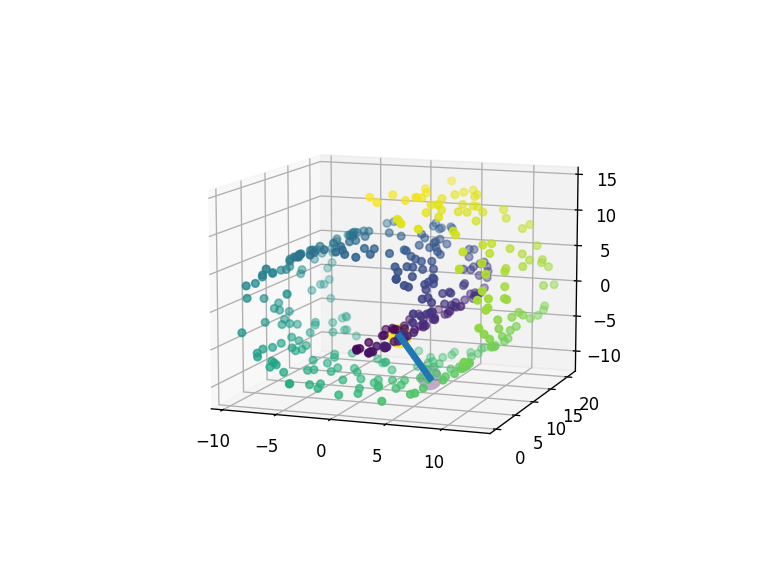

In [3]:
%matplotlib notebook
import matplotlib.pyplot as plt
from sklearn.datasets import make_swiss_roll, make_blobs
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

X, y = make_swiss_roll(n_samples=400, random_state=0)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[:,0], X[:,1], X[:,2], c=y)

p1, p2 = 93, 332
ax.scatter(X[[p1,p2],0], X[[p1,p2],1], X[[p1,p2],2], lw=10, c=[0,1], zorder=500)
ax.plot(X[[p1,p2],0], X[[p1,p2],1], X[[p1,p2],2], lw=4, zorder=500)

The marked points have a small euclidean distance in the 3-dimensional space above (indicated by the blue line), but only respecting the swiss roll itself, they are very far apart. The swiss roll is an example of a **manifold** (recall lecture 01), which has various competing, but equivalent definitions. For us it should suffice to say that that at each point's immediate neighborhood, it looks like an $\mathcal{R}^n$. In this case, when you zoom in close enough, the data will look like an $\mathcal{R}^2$. This is a 2-dimensional manifold *embedded* into a 3-dimensional space. 

Euclidean distance is not a faithful measure of distance on such a manifold and hence, all methods based on this measure are bound to fail, or at least yield suboptimal results. Enter **manifold learning** techniques. There are various competing algorithms, and depending on the circumstances, some work better or faster than others. Here, we'll concentrate solely on **t-distributed Stochastic Neighborhood Embedding**, which is an immensely popular technique for nonlinear dimensionality reduction, but not straight-forward to interpret in the end. The underlying idea of all manifold learning techniques is that the data dimensions are excessive, and the true distribution is low-dimensional, but "wrapped" in high-dimensional space.

The bird's eye perspective on t-SNE is that it calculates a "similarity" measure in the high-dimensional space, another one in a low-dimensional space, and an objective function which tries to maximize the similarity. In detail, the following things happen:

 - The algorithm overlays a *Gaussian distribution* over each point $x_i$, then calculates the probabilities for some points $x_j$ in the vicinity of $x_i$ with $p(x_j|x_i)=\frac{\exp(-|| x_i - x_j ||^2 / 2 \sigma_i^2)}{\sum _{k\neq i}\exp(-|| x_i - x_k||^2 / 2 \sigma_i^2)}$
 - Compute the similarity $p_{ij} = \frac{p(x_j|x_i) + p(x_i|x_j)}{2N}$ with $p_{ii} = 0$, $p_{ij} = p_{ji}$, and $\sum_j p_{ij} = 1$. The interpretation of this similarity is the probability that a point $x_i$ would accept $x_j$ as being its neighbor under the assumption that this probability is proportional to a Gaussian distribution centered at $x_i$.
 - Very roughly speaking, the standard deviation $\sigma$, which gives an estimate of the radius in which points are sufficiently similar to the center point, is related to **perplexity**. This is an important hyperparameter of t-SNE
 - The similarity of the lower-dimensional points $y_i$ is modeled by a *Student t-distribution* (sometimes called Cauchy distribution) $q_{ij}=\frac{(1 + || y_i - y_j ||^2)^{-1}}{\sum_k\sum_{l\neq k}(1 + || y_k - y_l ||^2)^{-1}}$
 - Minimize the **Kullback-Leibler divergence** $\text{KL}\left(P || Q\right) = \sum_{i\neq j} p_{ij} \log{\frac {p_{ij}}{q_{ij}}}$, which measures the difference between two probability distributions.
 - Minimizing the Kullback-Leibler divergence (also called relative entropy) is an optimization task, usually performed via gradient descent, and yields the low-dimensional representations $y_i$.
 
The Kullback-Leibler divergence is the *objective* or *loss function* to t-sne. *Perplexity* is a hyperparameter that balances local and global aspects of the data, meaning it provides an upper bound for how far points are allowed to deviate from the assumed underlying manifold to still count as belonging to the local neighborhood of a point.

t-SNE plots aren't straightforward to interpret due to their probabilistic nature, so let's look at a few examples:

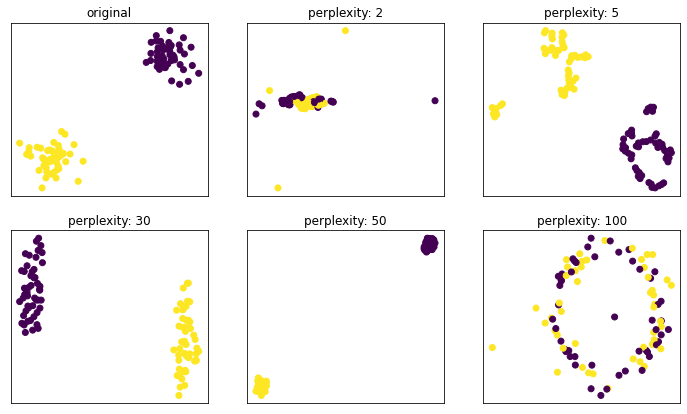

In [2]:
%matplotlib inline
from sklearn.manifold import TSNE

X, y = make_blobs(n_samples=100, centers=2, n_features=2, random_state=1)

params = [[2, 1000], 
          [5, 1000], 
          [30, 1000],
          [50, 1000],
          [100, 1000]]

fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(231)
ax.scatter(X[:,0], X[:,1], c=y)

ax.set_title("original")
ax.set_xticks([])
ax.set_yticks([])

for i,p in enumerate(params):
    tsne = TSNE(n_components=2, perplexity=p[0], n_iter=p[1])
    tsne_results = tsne.fit_transform(X)
    
    ax = fig.add_subplot(230+i+2)
    
    ax.scatter(tsne_results[:,0], tsne_results[:,1], c=y)
    
    ax.set_title("perplexity: " + str(p[0]))
    ax.set_xticks([])
    ax.set_yticks([])

The flattened cluster you're seeing in the fourth image often mean that the algorithm was stopped too early, so increasing the number of iterations makes sense. We see that perplexity heavily controls the results. When it's too low, the neighborhood of points is too small and many clusters appear in the result. When it's too high, too many points belong to clusters, such that no good separation is found. In the original paper, the authors suggest using values between 5 and 50 (smaller than the number of points, obviously) and testing multiple times which values make most sense.

A perplexity of 50 seems to work well. Unfortunately, the sciki-learn implementation does not allow iteration counts below 250, so we cannot visualize what happens before that.

In the plot below, the same reductions are performed for two clusters that differ in size (standard deviation):

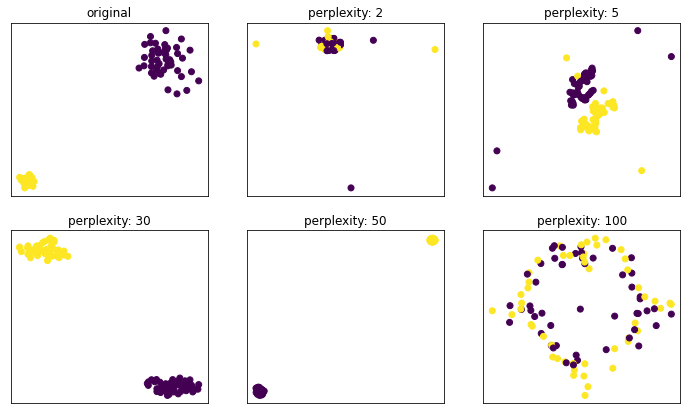

In [7]:
X, y = make_blobs(n_samples=100, centers=2, n_features=2, random_state=1, cluster_std=[1, 0.2])

params = [2, 5, 30, 50, 100]

fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(231)
ax.scatter(X[:,0], X[:,1], c=y)

ax.set_title("original")
ax.set_xticks([])
ax.set_yticks([])

for i,p in enumerate(params):
    tsne = TSNE(n_components=2, perplexity=p, n_iter=1000)
    tsne_results = tsne.fit_transform(X)
    
    ax = fig.add_subplot(230+i+2)
    
    ax.scatter(tsne_results[:,0], tsne_results[:,1], c=y)
    
    ax.set_title("perplexity: " + str(p))
    ax.set_xticks([])
    ax.set_yticks([])

The cluster size in the resulting t-SNE plot does not reflect the original cluster sizes. They look the same in the plots that converged. This is because the notion of similarity in t-SNE is a local one. As such, it expands dense clusters and contracts wide ones.

Let's see what happens to the distance of clusters themselves:

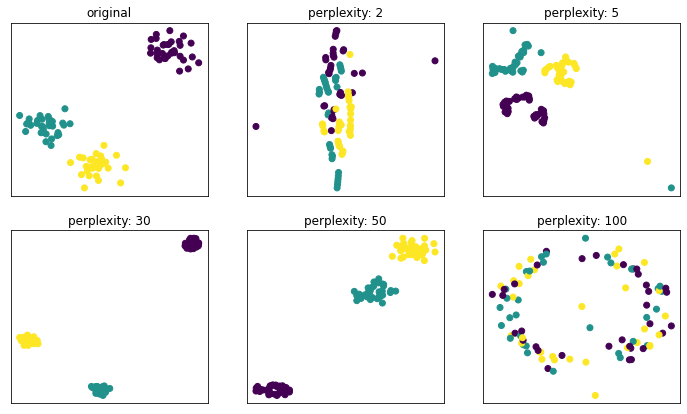

In [8]:
X, y = make_blobs(n_samples=100, centers=3, n_features=2, random_state=1)#, cluster_std=[1, 0.2])

params = [2, 5, 30, 50, 100]

fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(231)
ax.scatter(X[:,0], X[:,1], c=y)

ax.set_title("original")
ax.set_xticks([])
ax.set_yticks([])

for i,p in enumerate(params):
    tsne = TSNE(n_components=2, perplexity=p, n_iter=1000)
    tsne_results = tsne.fit_transform(X)
    
    ax = fig.add_subplot(230+i+2)
    
    ax.scatter(tsne_results[:,0], tsne_results[:,1], c=y)
    
    ax.set_title("perplexity: " + str(p))
    ax.set_xticks([])
    ax.set_yticks([])

In some of the plots, the global relative position of the clusters is reflected, while in others, it is not and instead they are more or less equidistant. t-SNE can, inprinciple, depict the relative position of clusters, but this necessitates fine-tuning the perplexity (the correct value depends on the number of points in each cluster). In general, the relative position of clusters in the reduced plots are not reliable predictors of the relative positions of the original clusters.

One reason for why it's necessary for t-SNE plots to do them multiple times with different hyperparameters is that they sometimes portray random data as having clusters:

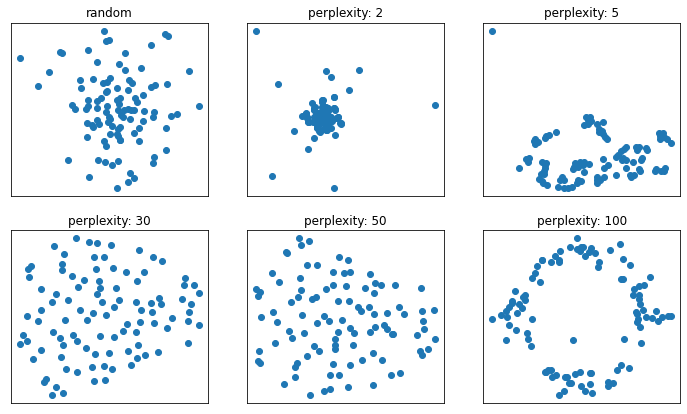

In [9]:
from sklearn.datasets import make_gaussian_quantiles

X, Y = make_gaussian_quantiles(n_features=2)

params = [2, 5, 30, 50, 100]

fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(231)
ax.scatter(X[:,0], X[:,1])

ax.set_title("random")
ax.set_xticks([])
ax.set_yticks([])

for i,p in enumerate(params):
    tsne = TSNE(n_components=2, perplexity=p, n_iter=1000)
    tsne_results = tsne.fit_transform(X)
    
    ax = fig.add_subplot(230+i+2)
    
    ax.scatter(tsne_results[:,0], tsne_results[:,1])
    
    ax.set_title("perplexity: " + str(p))
    ax.set_xticks([])
    ax.set_yticks([])

The very low and very high perplexity plots show some structure, where clearly none can be. This can be deceiving when dismissing the step to perform multiple plots.

Let's see what happens to parallel lines:

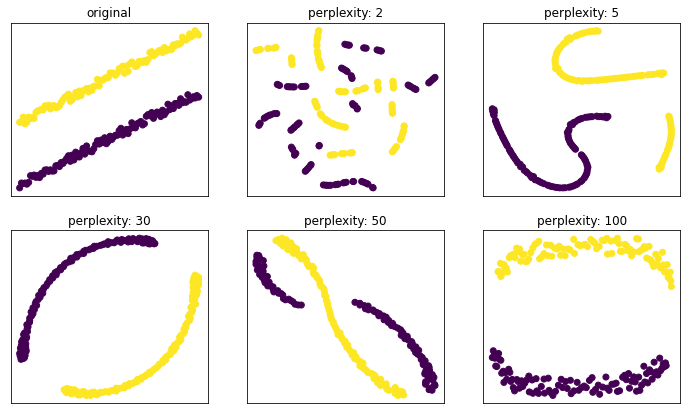

In [20]:
import numpy as np

n_points = 100
x = np.linspace(0, 10, n_points)

y1 = 0.3*x + 0.3*np.random.random(n_points)
y2 = 0.3*x + 2 + 0.3*np.random.random(n_points)

X = np.zeros([2*n_points, 2])
X[:n_points,0] = x
X[n_points:,0] = x
X[:n_points,1] = y1
X[n_points:,1] = y2

y = np.zeros(2*n_points)
y[n_points:] = 1

params = [2, 5, 30, 50, 100]

fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(231)
ax.scatter(X[:,0], X[:,1], c=y)

ax.set_title("original")
ax.set_xticks([])
ax.set_yticks([])

for i,p in enumerate(params):
    tsne = TSNE(n_components=2, perplexity=p, n_iter=500)
    tsne_results = tsne.fit_transform(X)
    
    ax = fig.add_subplot(230+i+2)
    
    ax.scatter(tsne_results[:,0], tsne_results[:,1], c=y)
    
    ax.set_title("perplexity: " + str(p))
    ax.set_xticks([])
    ax.set_yticks([])

Here, we needed to increase the number of iterations to get good results. The curves are depicted almost faithfully in most cases, but slightly curved outwards. The reason is that the regions in the middle of the lines are mode densely populated with samples than the ends. As explained above, t-SNE is sensitive to dense and wide distributions of points. This is reflected in the examples above.

The last important property is topology preservation. See for example the enclosed rings from before:

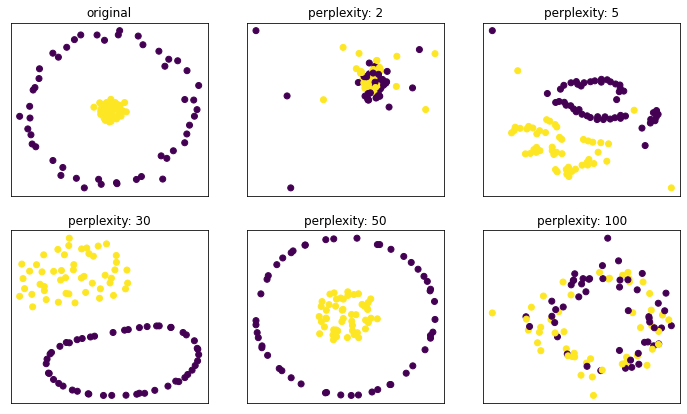

In [22]:
from sklearn.datasets import make_circles

X, y = make_circles(n_samples=100, factor=.1, noise=.05)

params = [2, 5, 30, 50, 100]

fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(231)
ax.scatter(X[:,0], X[:,1], c=y)

ax.set_title("original")
ax.set_xticks([])
ax.set_yticks([])

for i,p in enumerate(params):
    tsne = TSNE(n_components=2, perplexity=p, n_iter=500)
    tsne_results = tsne.fit_transform(X)
    
    ax = fig.add_subplot(230+i+2)
    
    ax.scatter(tsne_results[:,0], tsne_results[:,1], c=y)
    
    ax.set_title("perplexity: " + str(p))
    ax.set_xticks([])
    ax.set_yticks([])

Again, preserving the topology is highly dependent on fine-tuning the perplexity. This is also apparent when reducing the trefoil knot:

<IPython.core.display.Javascript object>


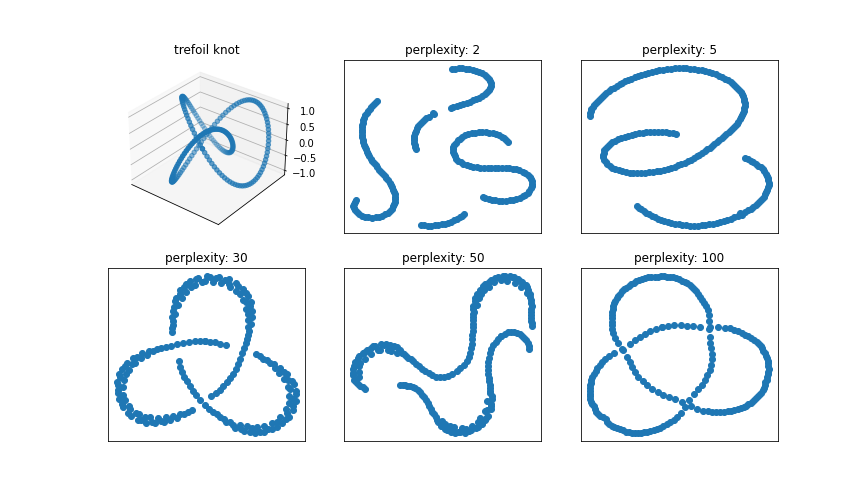

In [25]:
%matplotlib notebook
from sklearn.datasets import make_circles

ϕ = np.linspace(0, 2*np.pi, 200)
x = np.sin(ϕ)+2*np.sin(2*ϕ)
y = np.cos(ϕ)-2*np.cos(2*ϕ)
z = -np.sin(3*ϕ)

X = np.c_[x,y,z]

params = [2, 5, 30, 50, 100]

fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(231, projection='3d')
ax.scatter(X[:,0], X[:,1], X[:,2])

ax.set_title("trefoil knot")
ax.set_xticks([])
ax.set_yticks([])

for i,p in enumerate(params):
    tsne = TSNE(n_components=2, perplexity=p, n_iter=1000)
    tsne_results = tsne.fit_transform(X)
    
    ax = fig.add_subplot(230+i+2)
    
    ax.scatter(tsne_results[:,0], tsne_results[:,1])
    
    ax.set_title("perplexity: " + str(p))
    ax.set_xticks([])
    ax.set_yticks([])

With lower perplexities, t-SNE cuts the continuous line at some places to produce severed strings. The actual topology is preserved with higher perplexities and appropriate numbers of iterations.

What's left is to perform t-SNE on the swiss roll and compare the result to PCA and kernel-PCA:

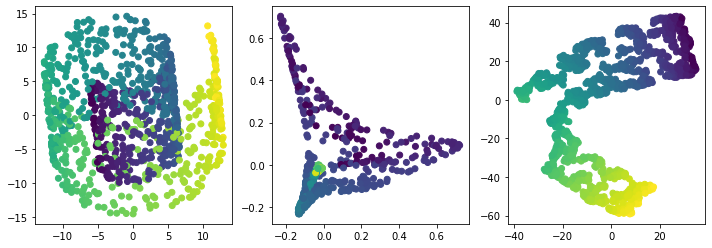

In [26]:
%matplotlib inline
from sklearn.decomposition import PCA, KernelPCA

X_swiss, y_swiss = make_swiss_roll(n_samples=1000, random_state=0)

techniques = [PCA(n_components=2), 
              KernelPCA(n_components=2, kernel='rbf', gamma=0.1), 
              TSNE(n_components=2, perplexity=30, n_iter=5000, init='pca')]

results = [red.fit_transform(X_swiss) for red in techniques]

fig, axes = plt.subplots(1,len(results), figsize=(12,4))

for i,ax in enumerate(axes):
    ax.scatter(results[i][:,0], results[i][:,1], c=y_swiss)
    


The configuration here doesn't quite manage to completely unfold the swiss roll, but it comes close and detects the connections of the data points quite well. There are other, more advanced techniques that easily unroll the dataset, which all make use of the manifold property of the dataset. Linear PCA only projects the swiss roll onto a 2D space, kernel-PCA finds an embedding that slightly respects the position of points, but only t-SNE find an embedding that almost faithfully represents the manifold.